This notebook is only a preliminary exploration of the effecient net model. It is used as a referent for future works. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing Libraries

In [2]:
%matplotlib inline

import os
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import argparse
import time
import PIL
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.optimizers import SGD,Adam

# Creating Custom Dataset

In [3]:
# image_size is determined by EfficientNet model B0
image_size = (224, 224)
batch_size = 64

train_df =tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Capstone/Dataset/train',
    image_size=image_size,
    batch_size= batch_size
)

test_df =tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Capstone/Dataset/test',
    image_size=image_size,
    batch_size= batch_size
)

Found 4682 files belonging to 3 classes.
Found 825 files belonging to 3 classes.


# Data Augmentation

In [4]:
train_df.class_names

['covid', 'normal', 'thoraxdisease']

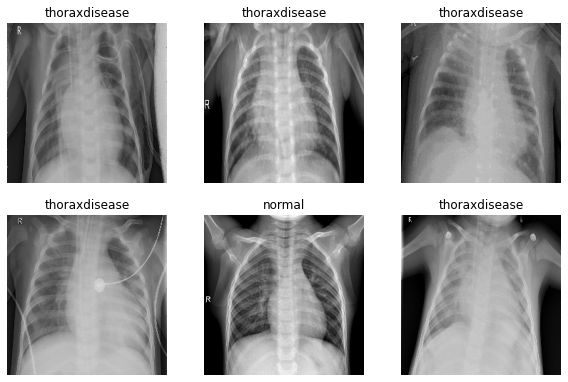

In [5]:
class_name = train_df.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_name[int(labels[i])])
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    layers.experimental.preprocessing.RandomFlip('horizontal')
)

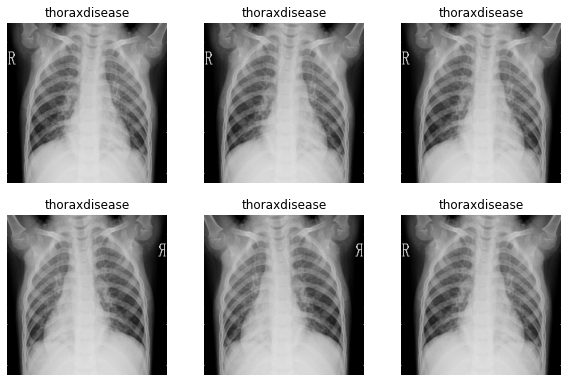

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_name[int(labels[0])])
        plt.axis("off")

## Preprocess the data

In [8]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()

train_ds = train_gen.flow_from_directory('/content/drive/MyDrive/Capstone/Dataset/train',
                                       target_size=image_size,
                                       batch_size= batch_size,
                                       seed=42)

test_ds = test_gen.flow_from_directory('/content/drive/MyDrive/Capstone/Dataset/test',
                                       target_size=image_size,
                                       batch_size= batch_size,
                                       seed=42)

Found 4682 images belonging to 3 classes.
Found 825 images belonging to 3 classes.


In [9]:
train_ds.labels.shape

(4682,)

In [10]:
#Defining the model
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224,3),classes=3)


#Adding the final layers to the above base models where the actual classification is done in the dense layers

model= Sequential()
model.add(base_model) 
model.add(Flatten()) 
base_model.trainable = False

#Model summary
base_model.summary()


16711680/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________

In [11]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))

model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
#model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(3,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 62720)             0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 1024)              64226304  
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 512)               524800    
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 256)               131328    
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 128)               32896     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 3)                

In [12]:
#Defining the parameters
batch_size= 100
epochs=12
learn_rate=3e-4

In [13]:
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate)

In [15]:
#Compiling the model
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])


In [16]:
#Learning Rate Annealer
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(   monitor='val_accuracy',   factor=.1,   patience=3,  min_lr=3e-5)

In [17]:
#Training the model
model.fit(train_ds, epochs = epochs, steps_per_epoch = train_ds.samples//batch_size, validation_data = test_ds, callbacks = [lrr], verbose = 2)

Epoch 1/12
46/46 - 1106s - loss: 0.4720 - accuracy: 0.8042 - val_loss: 0.2502 - val_accuracy: 0.9055
Epoch 2/12
46/46 - 457s - loss: 0.2076 - accuracy: 0.9141 - val_loss: 0.2188 - val_accuracy: 0.9224
Epoch 3/12
46/46 - 267s - loss: 0.1715 - accuracy: 0.9374 - val_loss: 0.1525 - val_accuracy: 0.9479
Epoch 4/12
46/46 - 228s - loss: 0.1364 - accuracy: 0.9522 - val_loss: 0.1384 - val_accuracy: 0.9503
Epoch 5/12
46/46 - 222s - loss: 0.1236 - accuracy: 0.9578 - val_loss: 0.1255 - val_accuracy: 0.9564
Epoch 6/12
46/46 - 218s - loss: 0.1073 - accuracy: 0.9671 - val_loss: 0.1412 - val_accuracy: 0.9503
Epoch 7/12
46/46 - 228s - loss: 0.1021 - accuracy: 0.9671 - val_loss: 0.1248 - val_accuracy: 0.9588
Epoch 8/12
46/46 - 222s - loss: 0.0953 - accuracy: 0.9685 - val_loss: 0.1169 - val_accuracy: 0.9564
Epoch 9/12
46/46 - 228s - loss: 0.0880 - accuracy: 0.9699 - val_loss: 0.1148 - val_accuracy: 0.9612
Epoch 10/12
46/46 - 220s - loss: 0.0767 - accuracy: 0.9758 - val_loss: 0.0988 - val_accuracy: 0.964

In [18]:
def plot_history(history):
  plt.rcParams['figure.figsize'] = (6,6)
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, 'red', label='Training acc')
  plt.plot(epochs, val_acc, 'blue', label='Validation acc')
  plt.legend()
  plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, 'red', label='Training loss')
  plt.plot(epochs, val_loss, 'blue', label='Validation loss')
  plt.legend()
  plt.show()

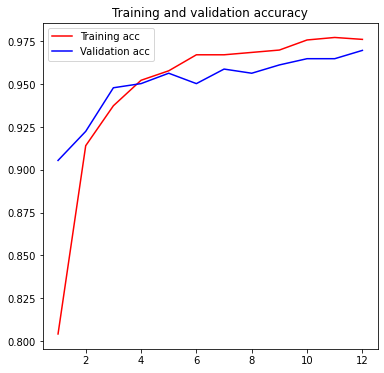

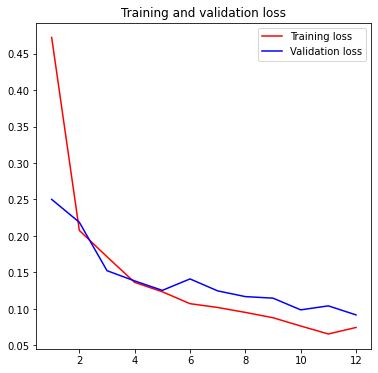

In [19]:
plot_history(model.history.history)